In [1]:
import os

os.chdir("../")
print(os.getcwd())

c:\Users\risko\Desktop\Prompt-Classification


In [2]:
import time
import statistics
import pickle
import random  

import numpy as np
import pandas as pd
import onnxruntime as ort
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn import metrics

from prompt_classifier.metrics import evaluate
from prompt_classifier.modeling.dspy_gpt import GPT4oMini
from prompt_classifier.modeling.fasttext import FastTextClassifier

#from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI

load_dotenv()
random.seed(42)

c:\Users\risko\miniconda3\envs\prompt-classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
providers = ort.get_available_providers()

print(providers)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [4]:
law_prompts = pd.read_csv('data/processed/law_prompts.csv')
general_prompts = pd.read_csv('data/processed/general_prompts.csv')
healthcare_prompts = pd.read_csv('data/processed/healthcare_prompts.csv')
finance_prompts = pd.read_csv('data/processed/finance_prompts.csv')

law_dataset = pd.concat([law_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
healthcare_dataset = pd.concat([healthcare_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)
finance_dataset = pd.concat([finance_prompts, general_prompts]).sample(frac=1).reset_index(drop=True)

datasets = {'law': law_dataset, 'healthcare': healthcare_dataset, 'finance': finance_dataset}

In [5]:
law_prompts_interim = pd.read_csv('data/interim/law_prompts.csv')
general_prompts_interim = pd.read_csv('data/interim/general_prompts.csv')
healthcare_prompts_interim = pd.read_csv('data/interim/healthcare_prompts.csv')
finance_prompts_interim = pd.read_csv('data/interim/finance_prompts.csv')

law_dataset_interim = pd.concat([law_prompts_interim, general_prompts_interim]).sample(frac=1).reset_index(drop=True)
healthcare_dataset_interim = pd.concat([healthcare_prompts_interim, general_prompts_interim]).sample(frac=1).reset_index(drop=True)
finance_dataset_interim = pd.concat([finance_prompts_interim, general_prompts_interim]).sample(frac=1).reset_index(drop=True)

datasets_interim = {'law': law_dataset_interim, 'healthcare': healthcare_dataset_interim, 'finance': finance_dataset_interim}

In [6]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2", providers=["CUDAExecutionProvider"]
    )

tfidf = TfidfVectorizer()

embedding_models = {'mini': mini_embedding, 'tfidf': tfidf, 'baai': baai_embedding}

In [7]:
print(f'BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}')
print(f'MiniLM available providers: {mini_embedding.model.model.get_providers()}')

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']


# GPT and ModernBERT loop using interim data

In [ ]:

for domain, dataset in datasets_interim.items():
    train_data = dataset.sample(frac=0.00025)
    test_data = dataset.drop(train_data.index).head(100)

    gpt_classifier = GPT4oMini(api_key=os.getenv("OPENAI_API_KEY"), proxy_url=os.getenv("PROXY_URL"), model_name="gpt-4o-mini",
                            domain=domain, train_data=train_data, test_data=test_data)


    gpt_classifier.optimize_model()

    predictions, actuals, mean_latency = gpt_classifier.predict()

    evaluate(predictions=predictions, true_labels=actuals, domain=domain, model_name="gpt4o-mini", embed_model="ada-002", cost=gpt_classifier.cost, latency=mean_latency)

    gpt_classifier.save_model(f"models/gpt-4o-mini-{domain}.json")

    break

    actuals = []
    predictions = []
    prediction_times = []

    # ModernBERT
    bert_classifier = ModernBERTNLI(domain=domain)
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):

        start_time = time.perf_counter_ns()
        prediction = bert_classifier.predict(row['prompt'])
        end_time = time.perf_counter_ns()

        actuals.append(row['label'])
        prediction_times.append(end_time - start_time)

        mean_prediction_time = statistics.mean(prediction_times)

    evaluate(predictions, actuals, domain, model_name='ModernBERT', embed_model='modernbert', latency=mean_prediction_time)


# SVM, fastText and XGBoost loop using processed data

In [8]:
def train_and_evaluate_model(
    model_name, 
    train_embeds, 
    test_embeds, 
    train_labels, 
    test_labels, 
    domain, 
    embed_model, 
    save_path
):
    """
    Train and evaluate a machine learning model (SVM or XGBoost).

    Parameters:
        model_name (str): Name of the model ('SVM' or 'XGBoost').
        train_embeds (ndarray): Training data embeddings.
        test_embeds (ndarray): Test data embeddings.
        train_labels (Series or ndarray): Training data labels.
        test_labels (Series or ndarray): Test data labels.
        domain (str): Domain name for logging purposes.
        embed_model (str): Embedding model used (e.g., 'tfidf', 'MiniLM').
        save_path (str): Path to save the trained model.

    Returns:
        None
    """
    # Initialize the classifier
    if model_name == 'SVM':
        classifier = SVC()
    elif model_name == 'XGBoost':
        classifier = XGBClassifier(n_jobs=-1)
    else:
        raise ValueError("Invalid model_name. Choose 'SVM' or 'XGBoost'.")

    print(f"Training {embed_model} embeddings on {domain} domain using {model_name}")

    # Train the model
    classifier.fit(train_embeds, train_labels)

    # Calculate training accuracy
    train_acc = metrics.accuracy_score(train_labels, classifier.predict(train_embeds))

    predictions = []
    prediction_times = []

    # Evaluate the model on test data
    for i, test_embed in enumerate(tqdm(test_embeds, desc=f"Evaluating {model_name} on {domain}")):
        start_time = time.perf_counter_ns()
        prediction = classifier.predict(test_embed.reshape(1, -1))
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)
        predictions.append(prediction[0])

    mean_prediction_time = statistics.mean(prediction_times)

    # Evaluate the predictions
    evaluate(
        predictions, 
        test_labels, 
        domain, 
        model_name=model_name, 
        embed_model=embed_model,
        latency=mean_prediction_time, 
        train_acc=train_acc
    )

    # Save the model
    with open(save_path, 'wb') as f:
        pickle.dump(classifier, f)

100%|██████████| 8000/8000 [00:00<00:00, 14098.83it/s]


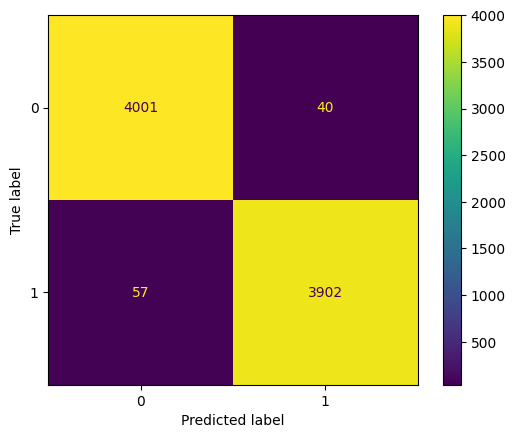

Training mini embeddings on law domain using SVM


Evaluating SVM on law: 100%|██████████| 8000/8000 [00:04<00:00, 1664.65it/s]


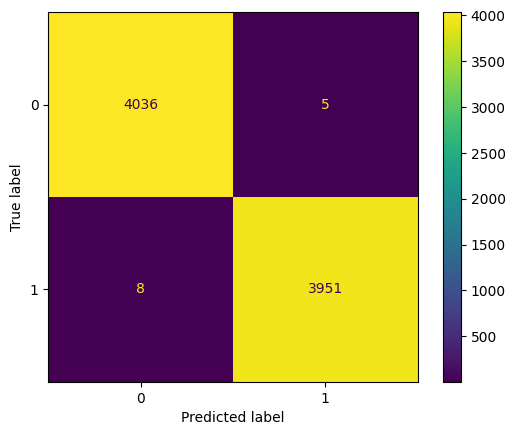

Training mini embeddings on law domain using XGBoost


Evaluating XGBoost on law: 100%|██████████| 8000/8000 [00:02<00:00, 3109.41it/s]


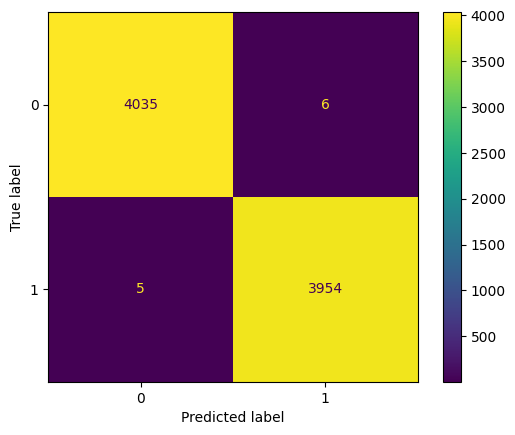

Training tfidf embeddings on law domain using SVM


Evaluating SVM on law: 8000it [00:27, 292.90it/s]


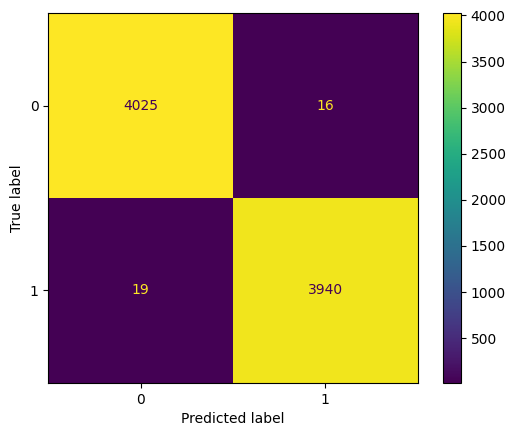

Training tfidf embeddings on law domain using XGBoost


Evaluating XGBoost on law: 8000it [00:56, 141.40it/s]


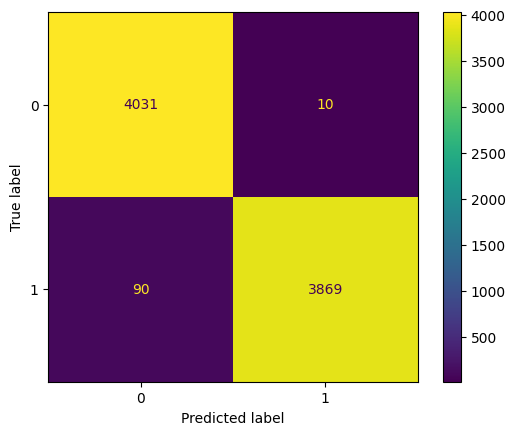

Training baai embeddings on law domain using SVM


Evaluating SVM on law: 100%|██████████| 8000/8000 [00:03<00:00, 2134.03it/s]


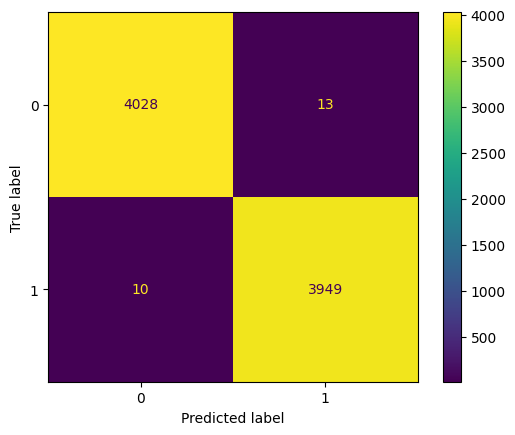

Training baai embeddings on law domain using XGBoost


Evaluating XGBoost on law: 100%|██████████| 8000/8000 [00:02<00:00, 3076.82it/s]


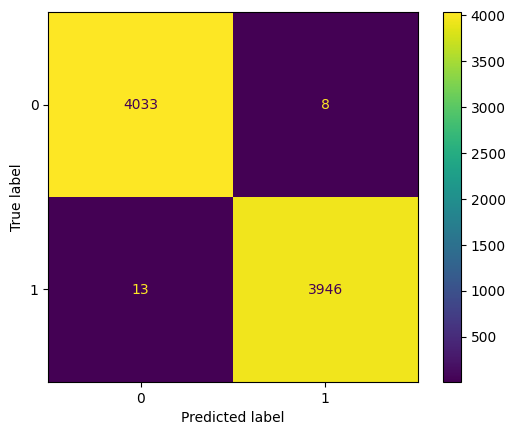

100%|██████████| 7998/7998 [00:00<00:00, 16272.63it/s]


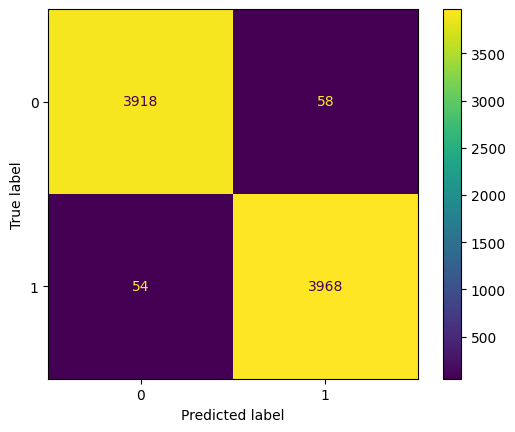

Training mini embeddings on healthcare domain using SVM


Evaluating SVM on healthcare: 100%|██████████| 7998/7998 [00:04<00:00, 1698.44it/s]


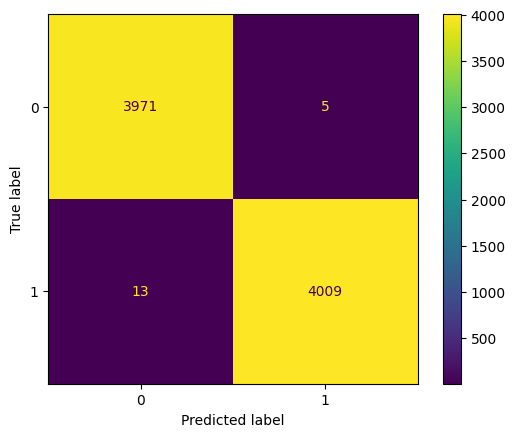

Training mini embeddings on healthcare domain using XGBoost


Evaluating XGBoost on healthcare: 100%|██████████| 7998/7998 [00:02<00:00, 3114.53it/s]


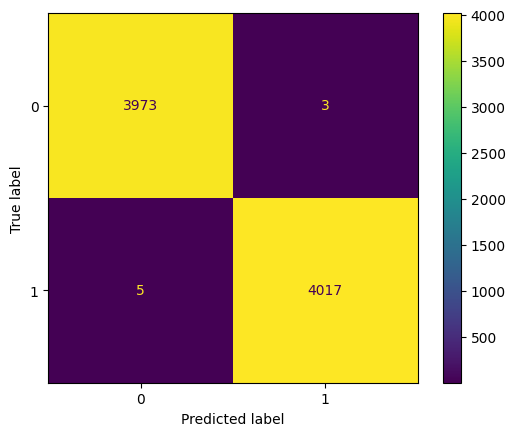

Training tfidf embeddings on healthcare domain using SVM


Evaluating SVM on healthcare: 7998it [00:18, 428.21it/s]


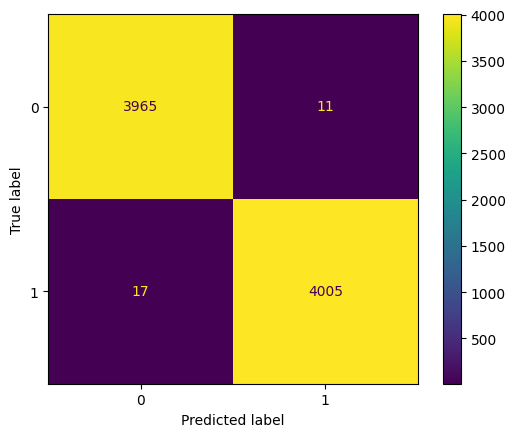

Training tfidf embeddings on healthcare domain using XGBoost


Evaluating XGBoost on healthcare: 7998it [00:38, 206.11it/s]


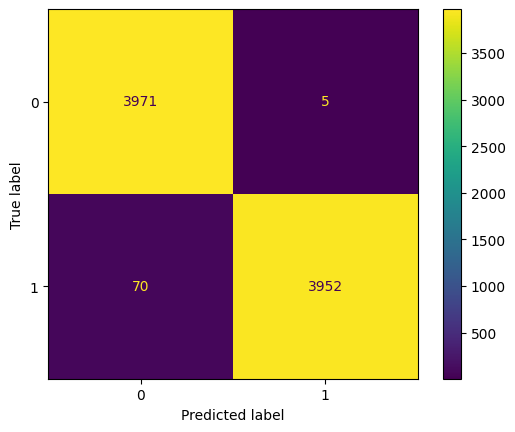

Training baai embeddings on healthcare domain using SVM


Evaluating SVM on healthcare: 100%|██████████| 7998/7998 [00:03<00:00, 2183.18it/s]


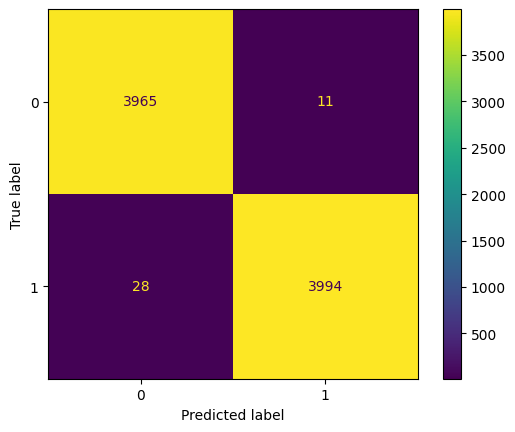

Training baai embeddings on healthcare domain using XGBoost


Evaluating XGBoost on healthcare: 100%|██████████| 7998/7998 [00:02<00:00, 3083.55it/s]


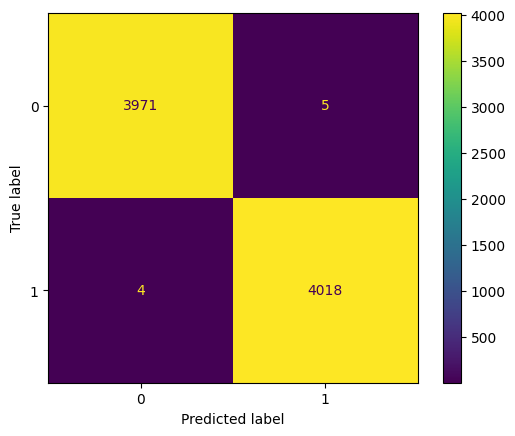

100%|██████████| 8000/8000 [00:00<00:00, 17319.76it/s]


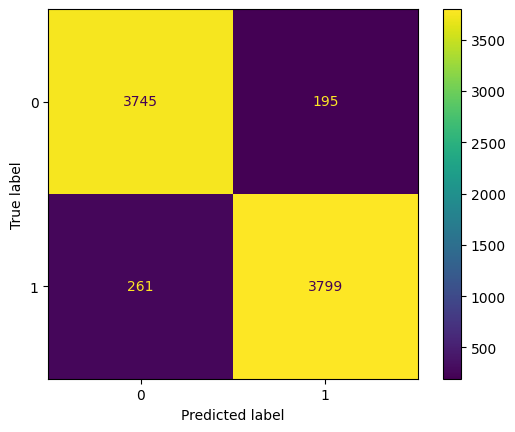

Training mini embeddings on finance domain using SVM


Evaluating SVM on finance: 100%|██████████| 8000/8000 [00:13<00:00, 592.97it/s]


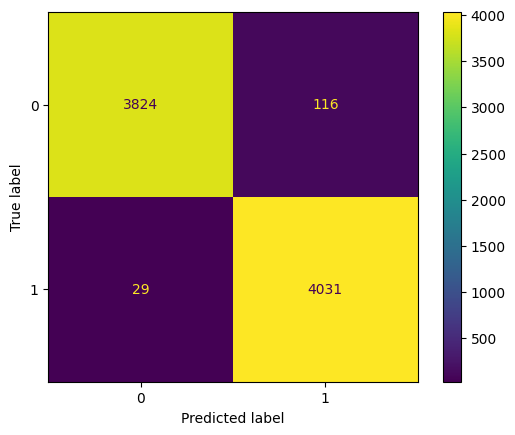

Training mini embeddings on finance domain using XGBoost


Evaluating XGBoost on finance: 100%|██████████| 8000/8000 [00:02<00:00, 3063.69it/s]


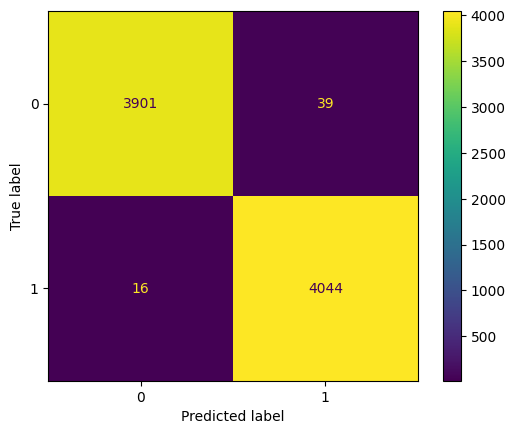

Training tfidf embeddings on finance domain using SVM


Evaluating SVM on finance: 8000it [00:14, 569.62it/s]


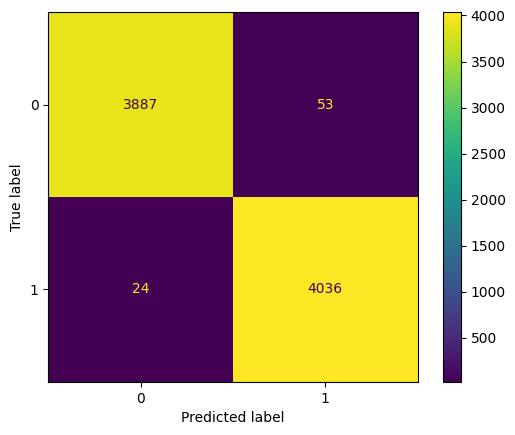

Training tfidf embeddings on finance domain using XGBoost


Evaluating XGBoost on finance: 8000it [00:13, 595.63it/s]


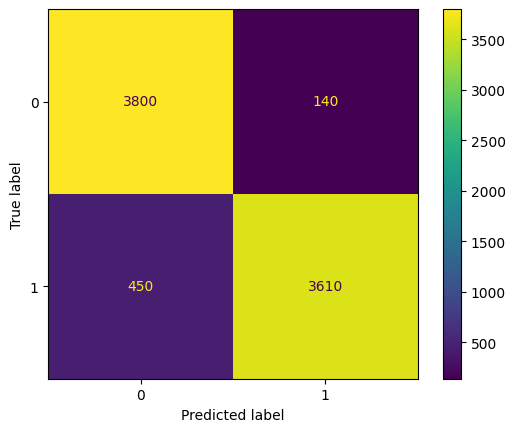

Training baai embeddings on finance domain using SVM


Evaluating SVM on finance: 100%|██████████| 8000/8000 [00:11<00:00, 705.02it/s]


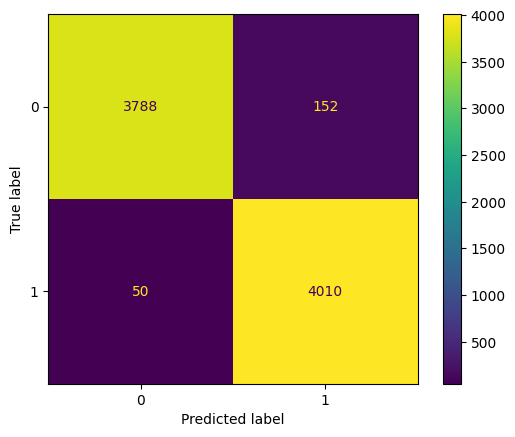

Training baai embeddings on finance domain using XGBoost


Evaluating XGBoost on finance: 100%|██████████| 8000/8000 [00:02<00:00, 3060.00it/s]


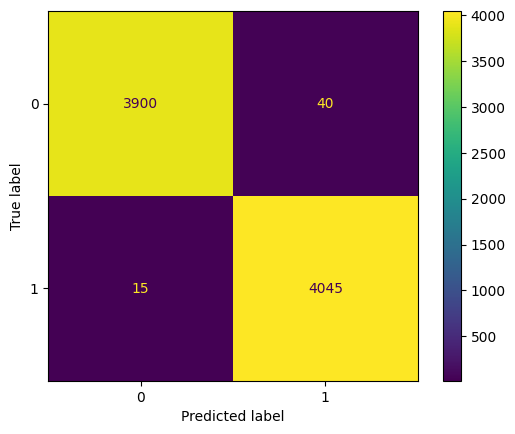

In [9]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.8).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    fasttext_classifier = FastTextClassifier(train_data=train_data, test_data=test_data)
    fasttext_classifier.train()

    train_predictions = []
    for _, row in train_data.iterrows():
        query = str(row['prompt']).replace('\n', '')
        prediction = fasttext_classifier.model.predict(query)
        train_predictions.append(1 if prediction[0][0] == '__label__1' else 0)
    train_acc_fasttext = metrics.accuracy_score(train_data['label'], train_predictions)


    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        text = str(row['prompt'])
        query = text.replace('\n', '')

        start_time = time.perf_counter_ns()
        prediction = fasttext_classifier.model.predict(query)
        end_time = time.perf_counter_ns()

        prediction_times.append(end_time - start_time)

        if prediction[0][0] == '__label__1':
            predictions.append(1)
        else:
            predictions.append(0)

        actuals.append(row['label'])

    mean_prediction_time = statistics.mean(prediction_times)
    evaluate(predictions, actuals, domain, model_name='fastText', embed_model='fasttext', 
            latency=mean_prediction_time, train_acc=train_acc_fasttext)

    fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")

    for model_name, embedding_model in embedding_models.items():
        if model_name == 'tfidf':
            embedding_model.fit(train_data['prompt'])
            with open(f"models/tfidf_{domain}.pkl", 'wb') as f:
                pickle.dump(embedding_model, f)
            train_embeds = embedding_model.transform(train_data['prompt'])
            test_embeds = embedding_model.transform(test_data['prompt'])

        else:
            train_embeds = np.array(list(embedding_model.embed(train_data['prompt'])))
            test_embeds = np.array(list(embedding_model.embed(test_data['prompt'])))


        # Train and evaluate SVM model
        train_and_evaluate_model(
            model_name='SVM',
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data['label'],
            test_labels=test_data['label'],
            domain=domain,
            embed_model=model_name,
            save_path=f'models/SVM_{domain}_{model_name}.pkl'
        )

        # Train and evaluate XGBoost model
        train_and_evaluate_model(
            model_name='XGBoost',
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data['label'],
            test_labels=test_data['label'],
            domain=domain,
            embed_model=model_name,
            save_path=f'models/XGBoost_{domain}_{model_name}.json'
        )